<a href="https://colab.research.google.com/github/MarcoFogale/PetitesAnnoncesTraining/blob/main/04_Comprehensive_Model_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Capstone Project by Marco Fogale**

# **A Machine Learning Approach to Vehicle Price Prediction in Peer-to-Peer Used Car Sales**

# 04 - Comprehensive Model Evaluation and Deployment Guidelines

**Objectives**
- Comprehensive Evaluation of the Optimal Model by Market Segment
- Test the Chosen Model on Unseen Data Collected One Quarter Later to Measure Performance Over Time
- Deployment Recommendations
- Closing Remarks and Acknowledgements

### **Load Dependecies and Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
sys.path.append('/content/drive/MyDrive/_CapstoneProject_')

import preliminary_data_cleaning as pdc
import data_clean_preprocess as dcp
import plot_residuals as plt_res

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

import joblib

SEED = 73
BASE_PATH = '/content/drive/MyDrive/_CapstoneProject_/'

Mounted at /content/drive


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# **In-Depth Best Model Assessment**

As shown in the previous section, the best model achieves a Mean Absolute Error (MAE) of 4,189 CHF on the entire dataset. However, this value appears to be a reliable estimate mainly for luxury cars, where higher prices leave more room for negotiation.

To gain a deeper understanding of the model's performance, we decided to enrich the dataset with an element not present in the original <i>petitesannonces</i> data: the market segment.

This classification, based on a common ISO standard for the European car market, groups vehicles by body shape. It often has a direct impact on car prices, as insurance companies also rely on it to determine annual premiums.

We created a market_segment_classification dataset, researching on [Wikipedia](https://en.wikipedia.org/wiki/Car_classification) the euro car segment and the vehicle size class (which we called <i>market_segment</i>) for each of the original July dataset's models.

We will evaluate the model within each segment and assess its suitability for accurate price prediction.

>**Load best model - Voting Regressor**

In [ ]:
best_model = joblib.load(os.path.join(BASE_PATH, "voting_regressor.pkl"))

>**Load Original July 2025 data, clean and preprocess dataset (using the same train–test split to ensure reproducibility)**

In [ ]:
july_df = pd.read_csv(os.path.join(BASE_PATH, "petites_annonces_cars.csv"), index_col=0)
features_dict, df  = dcp.data_clean_preprocess(july_df)

In [ ]:
X= df.drop(columns=['price'])
y= df['price']
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=0.25, random_state=SEED)

In [ ]:
y_pred = best_model.predict(X_test)
print(f'global MAE: {mean_absolute_error(10**y_test, 10**y_pred)}')

global MAE: 4185.051345811139


>**Load Wikipedia Car's Classification and Merge Datasets**

In [ ]:
wiki_df = pd.read_csv(os.path.join(BASE_PATH, "market_segment_classification.csv"), index_col=0 , encoding='latin1')
display(wiki_df.head(5))
print(' ')
print('Euro Car Segments (unique values)')
print(wiki_df['euro_car_segment'].unique())
print(' ')
print('Market Segments (unique values)')
print(wiki_df['market_segment'].unique())

wiki_df = wiki_df[['euro_car_segment', 'market_segment']]

,brand_model,brand,model_short,euro_car_segment,market_segment
reference_number,,,,,
5758485,ALFA ROMEO_1.9,ALFA ROMEO,1.9,C,Small family car
7396116,ALFA ROMEO_147,ALFA ROMEO,147,C,Small family car
6670147,ALFA ROMEO_147,ALFA ROMEO,147,C,Small family car
7058826,ALFA ROMEO_147,ALFA ROMEO,147,C,Small family car
4780291,ALFA ROMEO_147,ALFA ROMEO,147,C,Small family car


 
Euro Car Segments (unique values)
['C' 'D' 'E' 'S' 'B' 'F' 'A' 'J' 'M']
 
Market Segments (unique values)
['Small family car' 'Compact executive car' 'Executive car' 'Sports car'
 'Sport compact car' 'Supermini' 'Compact luxury crossover SUV'
 'Grand tourer' 'Full-size luxury car' 'Subcompact luxury crossover SUV'
 'City car' 'Mid-size luxury crossover SUV' 'Subcompact executive car'
 'Large family car' 'Compact crossover SUV' 'Light commercial vehicle'
 'Subcompact car' 'Full-size luxury crossover SUV' 'Minivan'
 'Subcompact crossover SUV' 'Large MPV' 'Mini MPV' 'Small MPV'
 'Compact MPV' 'Mid-size pickup truck' 'Mid-size crossover SUV'
 'Compact car' 'Full-size SUV' 'Mid-size luxury crossover 4x4'
 'Full-size luxury sport car' 'Sports supercars']


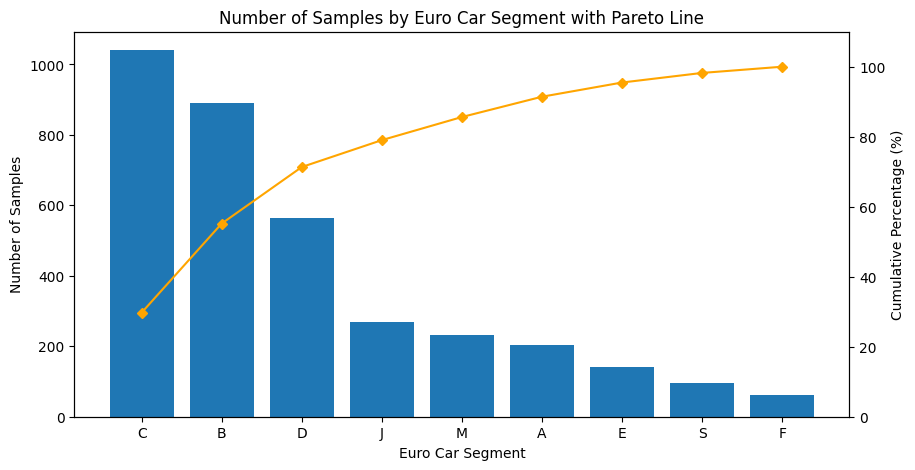

In [ ]:
counts = wiki_df['euro_car_segment'].value_counts()

cum_percentage = counts.cumsum() / counts.sum() * 100

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(counts.index, counts.values)
ax1.set_xlabel('Euro Car Segment')
ax1.set_ylabel('Number of Samples')

ax2 = ax1.twinx()
ax2.plot(counts.index, cum_percentage, color='orange', marker='D', ms=5)
ax2.set_ylabel('Cumulative Percentage (%)')
ax2.tick_params(axis='y')
ax2.set_ylim([0, 110])

plt.title('Number of Samples by Euro Car Segment with Pareto Line')
plt.show()

In [ ]:
print(f"percentage of C, B and D cars: {counts[counts.index.isin(['C','B','D'])].sum() / counts.sum() * 100:.2f}%")
print(f"percentage of J, M and A cars: {counts[counts.index.isin(['J','M','A'])].sum() / counts.sum() * 100:.2f}%")
print(f"percentage of E, S and F cars: {counts[counts.index.isin(['E','S','F'])].sum() / counts.sum() * 100:.2f}%")

percentage of C, B and D cars: 71.34%
percentage of J, M and A cars: 20.09%
percentage of E, S and F cars: 8.57%


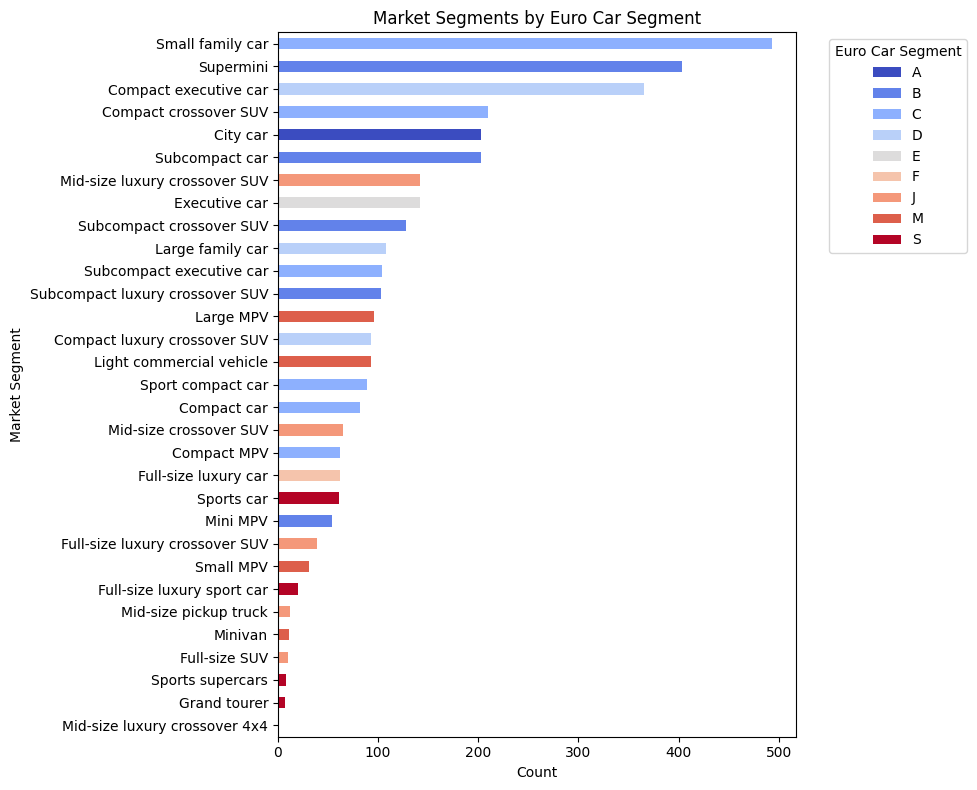

In [ ]:
counts = (wiki_df.groupby(["market_segment", "euro_car_segment"])
                  .size()
                  .reset_index(name="count"))

pivot_df = counts.pivot(index="market_segment",
                        columns="euro_car_segment",
                        values="count").fillna(0)

pivot_df = pivot_df.loc[pivot_df.sum(axis=1).sort_values(ascending=True).index]
ax = pivot_df.plot(kind="barh", stacked=True, figsize=(10, 8), colormap="coolwarm" )

ax.set_xlabel("Count")
ax.set_ylabel("Market Segment")
ax.set_title("Market Segments by Euro Car Segment")
plt.legend(title="Euro Car Segment", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

>**Observation**

The distribution analysis shows that approximately 70% of the entire July dataset listings (which we used for model training) belongs to the C, B and D segment (respectively small, medium and large cars). Multipurpose vehicles (M) and city cars (A) represents roughly 20% of the dataset, while luxury cars (F), executive cars (E) and sport cars (S) only represent a small portion of the dataset, approximately 9%.

Given the limited representation of certain categories, the model is expected to yield higher predictive accuracy for mass-market vehicles, while demonstrating reduced performance for underrepresented categories.

In [ ]:
rows = []

for euro_seg in wiki_df['euro_car_segment'].dropna().unique():
    seg_idx = wiki_df.index[wiki_df['euro_car_segment'] == euro_seg]
    df_seg = df.loc[df.index.intersection(seg_idx)]
    if len(df_seg) == 0:
        continue

    X_seg = df_seg.drop(columns=['price'])
    y_seg = df_seg['price']
    y_pred_seg = best_model.predict(X_seg)
    mae_seg = mean_absolute_error(10**y_seg, 10**y_pred_seg)

    rows.append({
        'euro_car_segment': euro_seg,
        'market_segment': f'entire {euro_seg} euro segment',
        'mae': mae_seg
    })

    for market_seg in wiki_df.loc[seg_idx, 'market_segment'].dropna().unique():
        m_idx = wiki_df.index[(wiki_df['euro_car_segment'] == euro_seg) &
                              (wiki_df['market_segment'] == market_seg)]
        df_seg_mkt = df.loc[df.index.intersection(m_idx)]
        if len(df_seg_mkt) == 0:
            continue

        X_seg_m = df_seg_mkt.drop(columns=['price'])
        y_seg_m = df_seg_mkt['price']
        y_pred_seg_m = best_model.predict(X_seg_m)
        mae_seg_m = mean_absolute_error(10**y_seg_m, 10**y_pred_seg_m)

        rows.append({
            'euro_car_segment': euro_seg,
            'market_segment': market_seg,
            'mae': mae_seg_m
        })

results_df = pd.DataFrame(rows)
results_df = results_df.reset_index(drop=True)

display(results_df.sort_values(['mae'], ascending=True).head(10))

display(results_df.sort_values(['mae'], ascending=False).head(10))

,euro_car_segment,market_segment,mae
24,B,Mini MPV,948.739731
6,C,Compact MPV,1264.938999
27,A,entire A euro segment,1503.828532
28,A,City car,1503.828532
20,B,Supermini,1548.234839
1,C,Small family car,2068.490989
22,B,Subcompact car,2148.772997
19,B,entire B euro segment,2162.757692
38,M,Minivan,2273.550771
7,C,Compact car,2307.600387


,euro_car_segment,market_segment,mae
16,S,Grand tourer,17355.212086
35,J,Mid-size luxury crossover 4x4,14722.807522
18,S,Sports supercars,14298.211921
15,S,Sports car,9375.101551
14,S,entire S euro segment,9173.443036
31,J,Full-size luxury crossover SUV,9067.278877
32,J,Mid-size pickup truck,5589.873786
30,J,Mid-size luxury crossover SUV,5404.520785
29,J,entire J euro segment,5293.227908
25,F,entire F euro segment,4908.701054


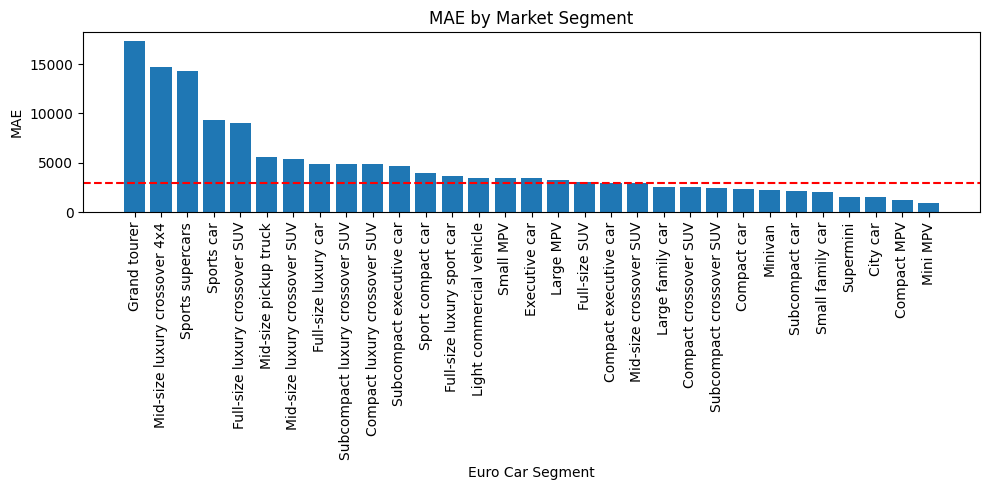

In [ ]:
seg_df = results_df[results_df['market_segment'].str[:6] !='entire'].copy()
seg_df = seg_df.sort_values('mae', ascending=False)

fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=3000, color='red', linestyle='--')
ax.bar(seg_df['market_segment'], seg_df['mae'])
ax.set_ylabel('MAE')
ax.set_xlabel('Euro Car Segment')
plt.xticks(rotation=90)
ax.set_title('MAE by Market Segment')


plt.tight_layout()
plt.show()

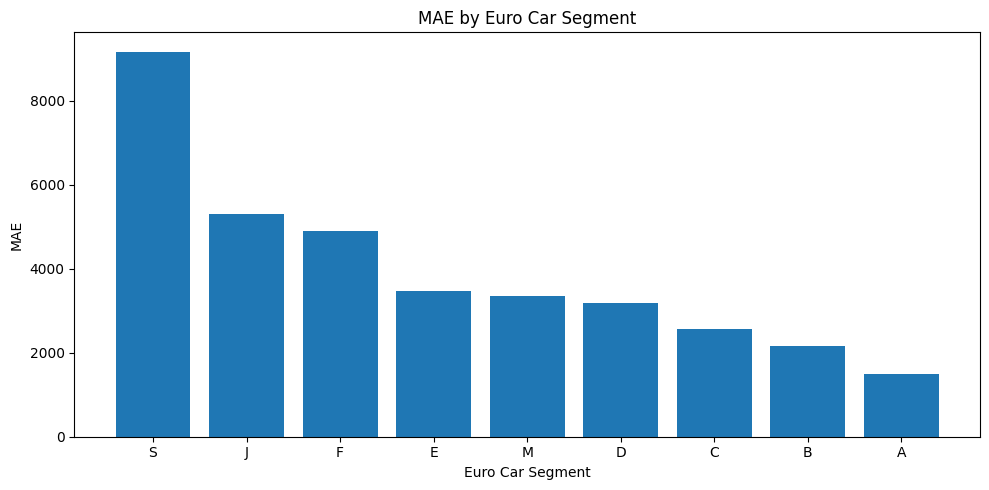

In [ ]:
seg_df = results_df[results_df['market_segment'].str[:6] =='entire'].copy()
seg_df = seg_df.sort_values('mae', ascending=False)

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(seg_df['euro_car_segment'], seg_df['mae'])
ax.set_ylabel('MAE')
ax.set_xlabel('Euro Car Segment')
ax.set_title('MAE by Euro Car Segment')


plt.tight_layout()
plt.show()

>**Conclusion**

Unexpectedly, the model exhibits robust predictive performance even within categories characterized by limited sample representation, such as City Cars (A-segment). The achievement of a Mean Estimation Absolute (MEA) below 4,000 CHF for large, high-value vehicles (E, M, and D segments) and below 2,000 CHF for smaller vehicles suggests a negotiation margin that remains within acceptable bounds. Consequently, the model may be regarded as sufficiently accurate for these categories.

Conversely, the model demonstrates suboptimal performance in the case of S (sports cars), J (SUVs), and F (luxury cars). This deficiency can plausibly be attributed to two primary factors:
- an insufficient number of observations, particularly within the J and F segments
- the irregular dynamics of the market

# **Model Performance Over Time Evaluation**

The car market evolves over time, as one of the main factors influencing price is the year of first registration. Consequently, the previously trained model will need to be periodically retrained in order to account for the introduction of new models, shifts in market trends (e.g., the evolution of electric vehicle prices, for which only limited samples were initially available), and the natural aging of vehicles already present in the dataset.

To evaluate the stability of the model over time, we collected the same population of listings from the website approximately three months later, in September 2025.

Our analysis proceeds in two steps. First, we compare listings present in both datasets to identify any modifications made in the interim (e.g., price adjustments). Second, we test model performance on the remaining samples, which were entirely unseen during training, to assess predictive accuracy on more recent data.

>**Load original dataset from July and the new dataset downloaded in September 2025**

In [ ]:
july_df = pd.read_csv('/content/drive/MyDrive/_CapstoneProject_/petites_annonces_cars.csv', index_col=0).drop_duplicates()
july_df = pdc.preliminary_data_cleaning(july_df)

september_raw_df = pd.read_csv('/content/drive/MyDrive/_CapstoneProject_/petites_annonces_cars_september.csv', index_col=0).drop_duplicates()
september_df = pdc.preliminary_data_cleaning(september_raw_df)

### **Datasets comparaison**

In [ ]:
print(f'Count of listings in July: {july_df.shape[0]}')
print(f'Count of listings in September: {september_df.shape[0]}')

common_listings_df = july_df.join(september_df,how='inner', lsuffix='_july', rsuffix='_september')
print(f'Count of listings that are still presents in september: {common_listings_df.shape[0]}')
common_listings_df = common_listings_df[['brand_july', 'brand_september', 'model_long_september', 'model_long_july','year_july','mileage_km_july', 'mileage_km_september', 'price_july', 'price_september' ]]

diff_km_same_price = common_listings_df[(common_listings_df['mileage_km_july'] != common_listings_df['mileage_km_september']) & (common_listings_df['price_july'] == common_listings_df['price_september'])]
print(f'Count of listings that are still presents in september, with a different mileage and the same price: {diff_km_same_price.shape[0]}')

diff_price = common_listings_df[common_listings_df['price_july'] != common_listings_df['price_september']].copy()
print(f'Count of listings that are still presents in september, with a different price: {diff_price.shape[0]}')

Count of listings in July: 3510
Count of listings in September: 3442
Count of listings that are still presents in september: 3060
Count of listings that are still presents in september, with a different mileage and the same price: 16
Count of listings that are still presents in september, with a different price: 141


In [ ]:
diff_price['price_july_original_scale'] = 10**diff_price['price_july']
diff_price['price_september_original_scale'] = 10**diff_price['price_september']
diff_price['price_difference'] = 10**diff_price['price_september'] - 10**diff_price['price_july']

print(f'Count of cars whose price augmented: {diff_price[diff_price["price_difference"] > 0].shape[0]}')
print(f'Count of cars whose price decreased: {diff_price[diff_price["price_difference"] < 0].shape[0]}')
print(f'Count of cars whose price decreased by more than 4000 CHF: {diff_price[diff_price["price_difference"] < -4000].shape[0]}')
print(' ')
print('Cars whose price augmented')
display(diff_price.sort_values(by='price_difference', ascending=False).head(10))
print(' ')
print('Cars whose price decreased the most')
display(diff_price[(diff_price['price_difference'] <=-3000)].sort_values(by='price_difference', ascending=True))

Count of cars whose price augmented: 10
Count of cars whose price decreased: 131
Count of cars whose price decreased by more than 4000 CHF: 19
 
Cars whose price augmented


,brand_july,brand_september,model_long_september,model_long_july,year_july,mileage_km_july,mileage_km_september,price_july,price_september,price_july_original_scale,price_september_original_scale,price_difference
reference_number,,,,,,,,,,,,
3411879,MERCEDES-BENZ,MERCEDES-BENZ,200 SLK,200 SLK,2007,15200,15200,4.227887,4.298853,16900.0,19900.0,3000.0
8050292,MINI,MINI,COOPER S STEPTRONIC DKG,COOPER S STEPTRONIC DKG,2019,99482,110000,4.332438,4.352183,21500.0,22500.0,1000.0
7901822,BMW,BMW,218 ACTIVÉ TOURER,218 ACTIVÉ TOURER,2015,129000,128000,3.995635,4.037426,9900.0,10900.0,1000.0
7917599,CHEVROLET,CHEVROLET,TRAX,TRAX,2013,150000,150000,3.698970,3.778151,5000.0,6000.0,1000.0
7843253,MINI,MINI,COOPER SD CABRIOLET,COOPER SD CABRIOLET,2013,83000,83000,4.113943,4.145818,13000.0,13990.0,990.0
8003270,FIAT,FIAT,124 SPIDER ABARTH,124 SPIDER ABARTH,2020,17700,17700,4.429752,4.439333,26900.0,27500.0,600.0
8055034,VW,VW,GOLF,GOLF,2013,65000,65000,4.089905,4.107210,12300.0,12800.0,500.0
4217376,FORD,FORD,KA 1.3,KA 1.3 FUN,2007,102000,72000,3.278754,3.380211,1900.0,2400.0,500.0
7538328,MERCEDES-BENZ,MERCEDES-BENZ,GLC 220 D 4MATIC 9G-TRONIC,GLC 220 D 4MATIC 9G-TRONIC,2015,150000,155000,4.311754,4.317854,20500.0,20790.0,290.0


 
Cars whose price decreased the most


,brand_july,brand_september,model_long_september,model_long_july,year_july,mileage_km_july,mileage_km_september,price_july,price_september,price_july_original_scale,price_september_original_scale,price_difference
reference_number,,,,,,,,,,,,
7785063,MERCEDES-BENZ,MERCEDES-BENZ,GLE 450 4MATIC,GLE 450 4MATIC,2022,27000,30000,4.951823,4.872156,89500.0,74500.0,-15000.0
7938428,AUDI,AUDI,RS6 FACELIFT,RS6 FACELIFT,2015,141000,150000,4.792392,4.672098,62000.0,47000.0,-15000.0
7987539,PORSCHE,PORSCHE,911 CARRERA S,911 CARRERA S,2007,107000,109000,4.716003,4.579784,52000.0,38000.0,-14000.0
7784424,FERRARI,FERRARI,CALIFORNIA,CALIFORNIA,2009,31300,31300,4.968483,4.903090,93000.0,80000.0,-13000.0
7785841,FORD,FORD,RANGER WILDTRACK 3.2,RANGER WILDTRACK 3.2,2016,147000,155000,4.408240,4.220108,25600.0,16600.0,-9000.0
4737355,VOLVO,VOLVO,V40 D3 SUMMUM,V40 D3 SUMMUM,2016,50000,130000,4.352183,4.130334,22500.0,13500.0,-9000.0
7877279,VOLVO,VOLVO,XC 60 R DESIGN T8 HYBRID,XC 60 R DESIGN T8 HYBRID,2020,74500,76000,4.648360,4.567026,44500.0,36900.0,-7600.0
7472419,LAND ROVER,LAND ROVER,DEFENDER 110,DEFENDER 110,2004,215000,217000,4.628389,4.544068,42500.0,35000.0,-7500.0
7945797,SKODA,SKODA,ENYAQ IV,ENYAQ IV,2022,34000,34000,4.568202,4.477121,37000.0,30000.0,-7000.0


>**Observation**

A substantial number of listings remain in the September dataset, alongside the addition of more than 300 new entries.

The most significant observation concerns listings that had already been present for several months, many of which experienced price adjustments. While a small fraction of these listings showed price increases, the majority saw reductions. In most cases, such decreases coincided with an increase in vehicle mileage: an expected outcome, as the cars continued to be used by their owners. Notably, most adjustments were below 4,000 CHF, representing a variation smaller than the global mean absolute error (MAE) measured in the model's performance evaluation.

A minority of listings presented more substantial price corrections. Of particular interest are several cases previously classified as “outliers” during model training, which subsequently had dramatic price reductions to align with market conditions. For instance, sample 7785063 recorded a price drop of 15,000 CHF.

The most pronounced price adjustments were observed among supercars, sports cars, and luxury vehicles, categories in which the model had shown suboptimal predictive accuracy. This pattern suggests that two factors are at play: first, the limited representation of these categories in the training dataset, which restricted the model's learning capacity; and second, the inherent instability of this market segment, where newly listed vehicles are often introduced at elevated prices that subsequently decrease sharply after remaining unsold for several months.

### **Model assessment on unseen, recent data**

>**Create Test Dataset from September 2025 data (only unseen, new listings, not present in the July 2025 dataset)**

In [ ]:
features_dict, sept_test_df = dcp.data_clean_preprocess(september_raw_df)
sept_test_df = sept_test_df[~sept_test_df.index.isin(july_df.index)]

print(f'Count of listings in September Test Dataset: {sept_test_df.shape[0]}')

Count of listings in September Test Dataset: 381


In [ ]:
sept_test_X = sept_test_df.drop(columns=['price'])
sept_test_y = sept_test_df['price']

In [ ]:
sept_test_y_pred = best_model.predict(sept_test_X)

Voting Regressor prediction (Sept 25 unseen data)
Test MAE (original scale): 4274.7876358489475
Test R^2 0.7541021832037966


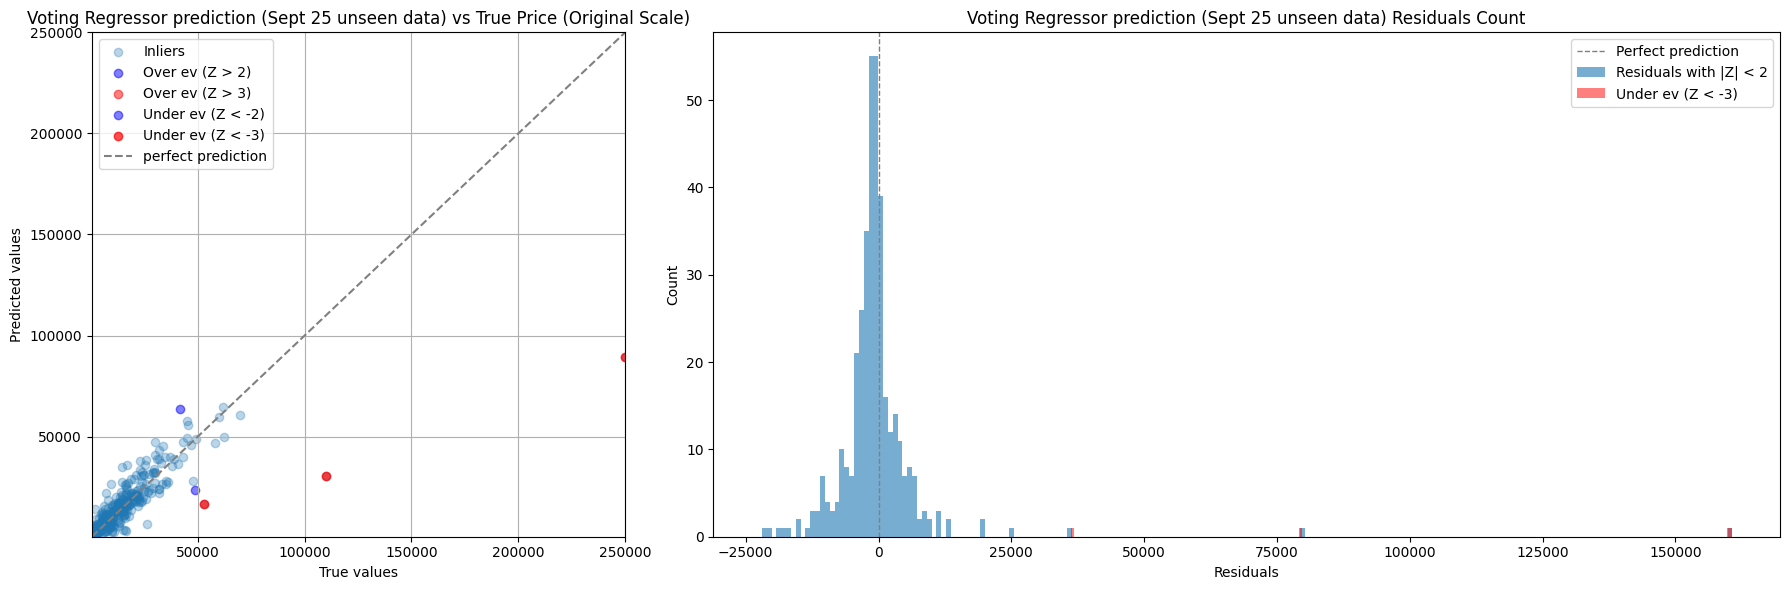

In [ ]:
model_name = 'Voting Regressor prediction (Sept 25 unseen data)'
print(model_name)

sept_r2  = r2_score(sept_test_y, sept_test_y_pred)
sept_mae = mean_absolute_error(10**sept_test_y, 10**sept_test_y_pred)
print("Test MAE (original scale):", sept_mae)
print("Test R^2", sept_r2)

plt_res.plot_residuals(sept_test_y, sept_test_y_pred, model_name)

>**Observation**

The model demonstrates robust predictive performance. Both the mean absolute error (MAE) and the coefficient of determination (R^2) remain consistent with the values obtained on the previous test dataset. Furthermore, the market appears to have remained relatively stable, as confirmed by the evaluation on entirely unseen data collected three months later.

Although regular retraining of the model is advisable to ensure continued accuracy, the current results suggest that such updates need not be frequent. A biannual retraining schedule would be sufficient to capture market dynamics while maintaining computational efficiency.

Overall, the observed patterns are highly consistent with earlier results, with only a limited number of outliers deviating from the general trend.

# **Conclusion and Deployment Recommandations**

The predictive framework developed in this project demonstrates satisfactory performance in estimating corrected market prices for vehicles belonging to categories A, B, C, D, and M. Within these segments, the model provides estimations that are sufficiently accurate to support practical applications, as the predicted values exhibit a close alignment with observed market data.

Conversely, the model reveals moderate limitations in categories J and F, where greater variability in pricing dynamics reduces predictive precision, and it performs inadequately in the domain of luxury sports cars, where data scarcity and heterogeneity in market drivers inhibit reliable generalization. These findings underscore the importance of segment-specific calibration when addressing heterogeneous vehicle classes.

From a temporal perspective, the model demonstrates stability across a minimum three-month interval, thereby confirming its short-term robustness. Nevertheless, due to the continuous evolution of the automotive market, including the release of new models, the depreciation of existing vehicles, and shifts in demand such as the growing influence of electric mobility, retraining at least twice per year is advised to ensure that performance remains adequate over time.

In summary, the proposed solution provides a solid and dependable foundation for predicting vehicle prices within mainstream categories, while its limitations in more specialized or niche segments suggest avenues for future refinement through enhanced data collection and tailored modeling approaches.

We advice to join to the website using the model's API this disclaimer:

><i>The price estimations provided by this tool are generated using a statistical learning model trained on historical data. While the model is sufficiently accurate for standard vehicle categories (A, B, C, D, M), results for other segments, in particular J, F, and luxury sports cars, may be less reliable. Predictions should therefore be interpreted as indicative estimates rather than definitive market values. Users are advised to complement these results with additional market research before making financial or commercial decisions.</i>

# **Acknowledgements**

We wish to extend our sincere gratitude to the school for providing the academic environment that made this work possible. We are especially grateful to the teaching staff for their guidance, expertise, and support throughout the entire course.